# 09_Benchmarks

- Silhoutte score
- ARI
- NMI
- LISI

In [10]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [12]:
import os
import simba as si

ModuleNotFoundError: No module named 'simba'

In [17]:
simba_spatial_fn = 'result_simba_spatial/adata_C.h5ad'
simba_spatial_adata_C = sc.read_h5ad(simba_spatial_fn)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'result_simba_spatial/adata_C.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
simba_spatial_adata_C

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'
    uns: 'color', 'pca', 'spatialLIBD_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'softmax'

In [9]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

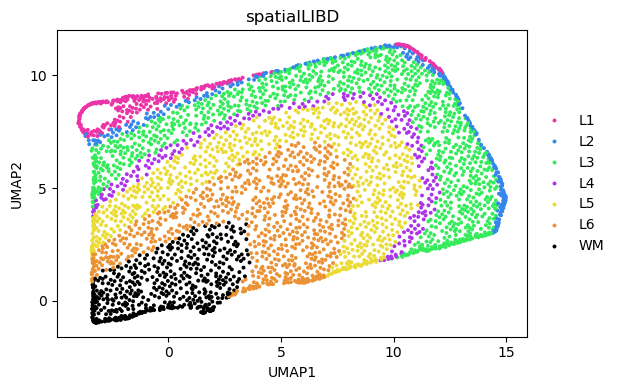

In [10]:
si.pl.umap(
    simba_spatial_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

Euclidean distance in graph embedding space

In [11]:
def get_pairwise_distance(adata):
    diff = adata.X[:, np.newaxis, :] - adata.X[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2) )
    return distances 

In [12]:
simba_spatial_adata_cell_dst = get_pairwise_distance(simba_spatial_adata_C)

In [13]:
simba_spatial_SC = silhouette_score(X=simba_spatial_adata_cell_dst, labels=simba_spatial_adata_C.obs['spatialLIBD'])

In [15]:
simba_spatial_SC

0.047347147

## RNA only

In [16]:
simba_rna_fn = 'result_simba_rnaseq_spatialLIBD/adata_C.h5ad'
simba_rna_adata_C = sc.read_h5ad(simba_rna_fn)

In [17]:
simba_rna_adata_C

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'
    uns: 'color'
    obsm: 'X_umap'

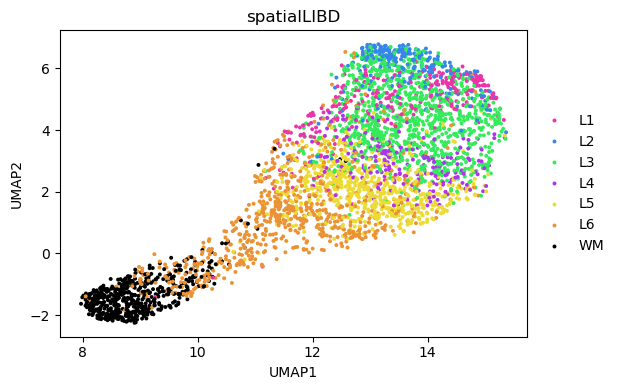

In [18]:
si.pl.umap(
    simba_rna_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [19]:
simba_rna_adata_cell_dst = get_pairwise_distance(simba_rna_adata_C)

In [24]:
simba_rna_adata_cell_dst.shape

(3611, 3611)

In [35]:
simba_rna_SC = silhouette_score(X=simba_rna_adata_cell_dst, labels=simba_rna_adata_C.obs['spatialLIBD'])
simba_rna_SC

-0.016990291

Just WM and L2 to confirm separation

In [34]:
fil = simba_rna_adata_C.obs['spatialLIBD'].isin(['WM', 'L2'])
wm_l2_simba_rna_SC = silhouette_score(
    X=simba_rna_adata_cell_dst[np.where(fil)[0]][:, np.where(fil)[0]], 
    labels=simba_rna_adata_C.obs.loc[fil]['spatialLIBD']
)
wm_l2_simba_rna_SC

0.41985822

Leiden score on the neighborhood generated from the cells' embeddings.

In [37]:
sc.pp.neighbors(simba_rna_adata_C)

In [38]:
sc.tl.leiden(simba_rna_adata_C)

/var/folders/h3/49kgmgs54yv7pd7wbst2wfv80000gp/T/ipykernel_15192/2711824279.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(simba_rna_adata_C)


In [41]:
simba_rna_adata_C.obs.head()

,spatialLIBD,leiden
AGTCTTCTCCTCAAAT-1,L5,5
GACTGGGCGCCGCAAC-1,L3,0
ACATCCCGGCCATACG-1,L6,5
ATAAGTAGGATTCAGA-1,L3,3
GATGGTGCCCTAGGCA-1,L3,3


Todo: Walktrap
- SpatialPCA paper: use SNN (shared nearest neighbors) in the low dimensional space
- Used Bluster package in R to rung Walktrap

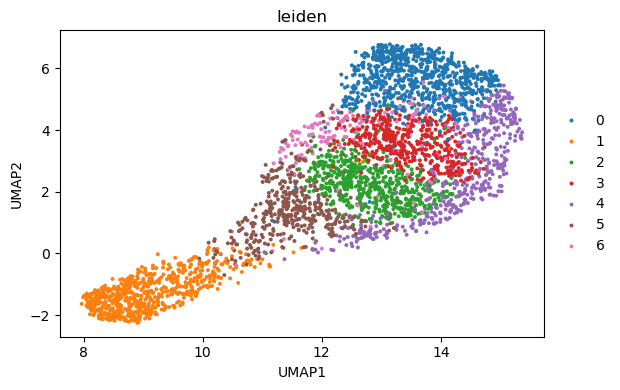

In [40]:
si.pl.umap(
    simba_rna_adata_C,color=['leiden'],
    # dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [43]:
adjusted_rand_score(simba_rna_adata_C.obs['spatialLIBD'], simba_rna_adata_C.obs['leiden'])

0.32167027216938654

In [45]:
fil = simba_rna_adata_C.obs['spatialLIBD'].isin(['WM', 'L2'])
adjusted_rand_score(simba_rna_adata_C.obs.loc[fil]['spatialLIBD'], simba_rna_adata_C.obs.loc[fil]['leiden'])

0.9135968049902432

In [47]:
normalized_mutual_info_score(simba_rna_adata_C.obs['spatialLIBD'], simba_rna_adata_C.obs['leiden'])

0.42159055638798953

In [48]:
normalized_mutual_info_score(simba_rna_adata_C.obs.loc[fil]['spatialLIBD'], simba_rna_adata_C.obs.loc[fil]['leiden'])

0.8271798844809072

# Spatial PCA test

In [13]:
test_spatialPCA_fn = 'data/08/151507_Spatial_PCA.spatialPCs.tsv'

In [14]:
test_spatialPCA_df = pd.read_csv(test_spatialPCA_fn, sep='\t')

In [15]:
test_spatialPCA_df.shape

(20, 4226)

In [17]:
import anndata as ad
from scipy.sparse import csr_matrix
import scanpy as sc

In [23]:
input_adata_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC/151507.h5ad"
input_adata = sc.read_h5ad(input_adata_fn)

In [33]:
test_spatialPCA_pcs = csr_matrix(test_spatialPCA_df.T, dtype=np.float32)
spatialPCA_adata = ad.AnnData(test_spatialPCA_pcs)
spatialPCA_adata.obs.index = test_spatialPCA_df.T.index
spatialPCA_adata.obs.loc[input_adata.obs.index, input_adata.obs.columns] = input_adata.obs.copy()

In [34]:
spatialPCA_adata.obs.loc[input_adata.obs.index]

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,spatialLIBD,leiden
AAACAACGAATAGTTC-1,1.0,0.0,16.0,723.0,6.584791,944.0,6.851185,22.457627,33.050847,44.597458,76.377119,L1,1
AAACAAGTATCTCCCA-1,1.0,50.0,102.0,2167.0,7.681560,4258.0,8.356790,25.011743,31.493659,40.183185,56.857680,L3,5
AAACAATCTACTAGCA-1,1.0,3.0,43.0,1090.0,6.994850,1966.0,7.584265,34.181078,42.065107,52.238047,69.989827,L1,1
AAACACCAATAACTGC-1,1.0,59.0,19.0,1890.0,7.544861,3362.0,8.120588,22.486615,29.982153,40.065437,58.596074,WM,6
AAACAGCTTTCAGAAG-1,1.0,43.0,9.0,1616.0,7.388328,2977.0,7.999007,27.208599,34.195499,44.171985,62.512597,L6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1.0,31.0,77.0,1320.0,7.186144,2337.0,7.757051,30.851519,38.040223,47.411211,64.912281,L3,3
TTGTTTCACATCCAGG-1,1.0,58.0,42.0,1441.0,7.273786,2328.0,7.753194,22.809278,30.111684,40.721649,59.579038,L6,2
TTGTTTCATTAGTCTA-1,1.0,60.0,30.0,629.0,6.445720,819.0,6.709304,25.030525,35.409035,47.619048,84.249084,WM,6
TTGTTTCCATACAACT-1,1.0,45.0,27.0,1690.0,7.433075,3084.0,8.034307,25.648508,32.879377,42.769131,61.413748,L6,0


In [41]:
spatialPCA_adata.X[:, 0].toarray().flatten()

array([ 1.8393947, -4.2017264,  8.300683 , ..., 10.263588 , -1.4169484,
        4.788635 ], dtype=float32)

<Axes: >

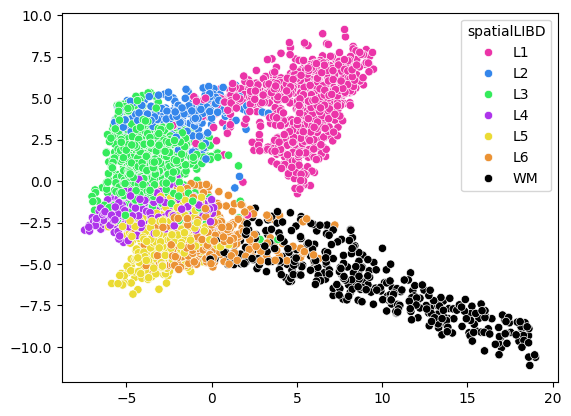

In [43]:
sns.scatterplot(
    x=spatialPCA_adata.X[:, 0].toarray().flatten(), y=spatialPCA_adata.X[:, 1].toarray().flatten(), 
    hue=spatialPCA_adata.obs["spatialLIBD"],
    palette=palette_celltype,
)

In [9]:
orig_counts_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/sandbox/data/08/151507_Spatial_PCA.counts.mtx"
orig_barcodes_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/sandbox/data/08/151507_Spatial_PCA.counts_barcodes.tsv"
orig_features_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/sandbox/data/08/151507_Spatial_PCA.counts_features.tsv"
orig_counts = sc.read_mtx(orig_counts_fn).T 
orig_counts.obs.index = pd.read_csv(orig_barcodes_fn, sep='\t', index_col=0, header=None).index
orig_counts.var.index = pd.read_csv(orig_features_fn, sep='\t', index_col=0, header=None).index

In [15]:
spatiapcs_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/sandbox/data/08/151507_Spatial_PCA.spatialPCs.tsv"
spatiapcs_df = pd.read_csv(spatiapcs_fn, sep='\t').T

In [16]:
spatiapcs_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
AAACAACGAATAGTTC-1,1.839395,-0.056199,0.119042,2.259855,-0.725211,4.093130,1.573811,-1.778881,-0.037088,-2.481347,-0.346806,0.488368,-0.090886,0.253823,0.170731,-0.437882,-1.593676,1.668662,-0.665284,0.467355
AAACAAGTATCTCCCA-1,-4.201727,-0.170725,-0.819069,-0.686498,1.279171,-1.377550,1.111251,0.318283,-0.017080,0.454137,0.764340,0.026916,0.718452,-0.332342,-0.268470,-0.011965,0.155432,0.085766,0.066909,0.267065
AAACAATCTACTAGCA-1,8.300683,8.129871,-2.846367,-3.876928,-1.510178,0.406901,-0.511099,-0.608551,1.509641,1.234727,2.693431,-0.351966,0.188704,-0.748463,-0.216341,0.596770,0.166731,0.002018,-0.543444,1.452717
AAACACCAATAACTGC-1,15.506971,-9.032115,5.197603,-4.409777,2.281120,-1.550275,-0.261735,1.773163,0.223588,-0.274610,-0.701520,-1.174049,1.063190,0.523419,0.463838,0.153683,-1.093420,-0.942415,1.582038,0.393294
AAACAGCTTTCAGAAG-1,-2.607732,-1.672119,-0.047331,-0.060465,-3.080737,1.288830,1.137290,2.335438,-2.892422,2.963015,0.465257,-0.953643,-0.387064,0.941461,1.582925,0.893057,0.777045,0.299622,0.632869,-0.688717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,-3.570138,2.295116,0.850384,-1.855272,1.060680,-0.192956,-0.799461,-0.620049,0.082094,-0.674391,-0.035997,0.044998,-0.630917,-0.392711,0.485392,-0.082227,-0.230249,0.279348,0.728739,-0.108338
TTGTTTCACATCCAGG-1,0.154489,-3.614464,1.909883,-0.325204,-2.360741,-0.081987,-0.339461,-1.574163,-1.502913,1.239670,-0.406029,0.986536,-1.195201,-0.468142,0.300594,-0.376596,0.186058,-0.003490,0.433085,-0.166736
TTGTTTCATTAGTCTA-1,10.263588,-7.831282,1.197176,2.795951,2.954796,2.209030,-0.286946,-1.219207,-2.845642,-0.242497,1.136468,2.561081,2.411186,-2.321241,-1.923542,1.137249,1.663073,1.270007,-1.125563,1.400282
TTGTTTCCATACAACT-1,-1.416948,-2.258155,-0.229966,-0.779317,-1.631400,0.862940,-1.129696,0.348372,0.290272,0.698826,-0.660294,-0.642558,0.723071,-0.166853,1.208623,0.245489,0.020395,-0.538052,-0.094886,-0.850528
